# Genetic Drift and Kimura Diffusion: Stochasticity in Simulated Populations using Deep Learning

 * Midhun Bhaskaran  
  based on Dwipayana (2024), *Time Series Prediction on Population Dynamics*, and by Kimura’s diffusion theory of allele frequencies.

---

## 1. Coin Flips

Modern population genetics stipulates that every organism carries genes, the code for life. Each gene can come in different versions called alleles, dominant, recessive, defective, all sorts. Across generations, allele frequencies change and are sustained not only because some variants are more advantageous for survival, but also because randomness plays a powerful part.

Even in a perfectly stable environment, small populations exhibit erratic behavior; chance events lead to the overrepresentation of some alleles(fixation) while others disappear entirely(extinction).This phenomenon is known as genetic drift, and it becomes stronger as populations grow smaller.

To understand this mathematically, classical models like Wright–Fisher were introduced as early as, in the 1920s.You might have learned this in high school. The model captured how allele frequencies vary due to random sampling in each generation. Despite its simplicity, the Wright–Fisher model remains paramount for how we study evolution and extinction risk, as modern models build on top of it. A useful way to see how this model works through the lens of coin flips.


To understand how genes drift through a population, we can use a random experiment design. Treat populations as 2 N tiny tokens, each carrying one of two possible allele types: Heads (H) and Tails (T). Every generation later, the tokens make 'offsprings', and the next generation is formed by randomly sampling from whatever was present before it.

Let's look at how repeated sampling can guide complex evolutionary behaviour.

Let k be the number of heads, in a generation t. The allele frequency is given by, $𝑝=𝑘/2𝑁$
To create the next generation,draw 2N tokens with replacement, each with a probability p that it is head. This is a binomial distribution.

$$k' \sim \mathrm{Binomial}(2N, p)$$
Therefore the new frequency is simply   
$$
p' = \frac{k'}{2N}.
$$

This is the crux of the Wright–Fisher model (1930). The surprising consequence is that even if neither allele has an advantage, the random sampling changes the population unpredictably. After enough generations pass, one allele inevitably wins and dominates, mostly because luck and noise carried it. 

## Aim
This project aims to simulate this process and test whether sequence models such as LSTM, Transformer, a straightforward Gaussian process etc(and xLSTM in a future version) can learn the stochastic trajectory of populations and the alleles' genetic drift.  

When the population is small, allele frequencies jump noisily from one generation to the next because each individual is a discrete sample.
But as N becomes large, these jumps become tame. The randomness is now smoother and continuous. In this limit, the Wright–Fisher model behaves less like coin flips and more like a particle nudged around by random forces; think diffusion in physics.

This smooth limit is described by Kimura’s diffusion equation, a continuous stochastic approximation that captures both the direction of evolutionary change and the uncertainty around it:
$$
dp = s\,p(1-p)\,dt + \sqrt{\frac{p(1-p)}{2N_e}}\,dW_t.
$$

$s\,p(1-p)\,dt$ is the deterministic part of evolution. If 𝑠>0, the allele has a selective advantage and tends to rise. s is called the section coefficient. If 𝑠<0, the allele tends to fall in its chances. As you might have guessed, the deterministic part is large and effective when both alleles are comparitively of the same ratio.

- $s$ – selection coefficient  
- $N_e$ – effective population size  
- $dW_t$ – Gaussian white noise increment  


The diffusion term is the stochastic component, representing genetic drift. 
$p(1-p)/(2N)$ determines the extent of randomness in the population, maximum at 𝑝=0.5 and 0 at fixation/extinction.
$N_e$ undercuts the randomness as larger populations drift less.
$dW_t$ is an is the pure Gaussian noise that accumulates over time unpredictably, in each infinitesimal step. This is the famous Wiener process.

Together, they spell out how allele frequencies vary. The final result is a noisy, state-dependent trajectory, and why we bring in deep learning.

## Why xLSTM?

In Dwipayana (2024), an LSTM successfully learned the **logistic map** $$x_{n+1} = \alpha x_n(1-x_n)$$.  
That’s a deterministic cousin of the Wright–Fisher model, in learning population growth with constraints. 
Here I extend the idea to use various sequential methods to learn stochastic diffusion variance $p(1-p)/(2N)$ from simulated population trajectories, and check with analytical solutions proposed by stochastic calculus.


This is a toy project run on cpu, so the models are small. The xLSTM and possibly TiRex will be run on a GPU, along with a bigger model of transformer, for fair comparison. I hypothesize that xLSTM will perform the best on the stochastic framework proposed, but there will be room for improvement as xLSTM isn't natively coded to predict long-term stochastic series forecasting. :


---
## Imports & Setup


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

## 3. The Wright–Fisher Simulator


In [2]:
def wf_simulate(N=100, s=0.0, gens=50, reps=1000, p0=0.5, seed=42):
    
    """
Simulate allele frequency trajectories under the Wright–Fisher model.
Parameters
----------
N : int
    Population size (diploid => 2N chromosomes, haploid would mean a single allele)
s : float
    Selection coefficient
gens : int
    Number of generations per replicate
reps : int
    Number of replicate trajectories
p0 : float
    Starting allele frequency
seed : int
    RNG seed

Returns
-------
pd.DataFrame with columns [rep, gen, p, N, s]
"""
    rng = np.random.default_rng(seed)
    data=[]
    for rep in range(reps):
        p = p0
        for t in range(gens):
        # selection-adjusted frequency
            p_sel = (1+s)*p / (1+s*p)
        # binomial sampling
            p = rng.binomial(2*N, p_sel)/(2*N)
            data.append((rep, t, p, N, s))
    return pd.DataFrame(data, columns=["rep","gen","p","N","s"])

In [3]:
df = wf_simulate(N=100, s=0.02, reps=500)
df.head()

,rep,gen,p,N,s
0,0,0,0.560,100,0.02
1,0,1,0.580,100,0.02
2,0,2,0.600,100,0.02
3,0,3,0.565,100,0.02
4,0,4,0.625,100,0.02



### Explanation  
We loop over not copies but 'offsprings' as each generation samples new allele frequencies.  
The dataframe `df` is our 'habitat' of populations.

---

## 4. Quick Visual Check


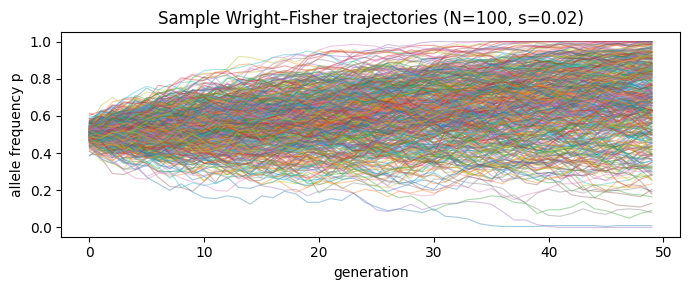

In [4]:
plt.figure(figsize=(7,3))
for r, g in df.groupby("rep"):
    plt.plot(g.gen, g.p, lw=0.8, alpha=0.4)
plt.xlabel("generation")
plt.ylabel("allele frequency p")
plt.title("Sample Wright–Fisher trajectories (N=100, s=0.02)")
plt.tight_layout()
plt.show()


The plot above shows several independent Wright–Fisher trajectories.  
Each starts at the same allele frequency and drifts stochastically through time due to finite population sampling.  
Notice how some trajectories approach fixation (p to 1) while others lose the allele by extinction (p to 0).  
Even without selection (s close to 0), random sampling alone can drive allele types to extinction.



## 5. Exploring Data&Theory 

Before we train the data on any neural network that models sequences, let’s first look closely at what the data represents.

We’ve simulated allele-frequency trajectories using the Wright–Fisher model, a stochastic model in which each generation is a random sample of the previous one.

Each row in our dataset corresponds to:
- a **replicate** index (independent population),
- a **generation** number,
- the **allele frequency** p (fraction of “A” alleles),
- the population size N, and
- the selection coefficient s.

The goal of our models will be to learn how p changes from one generation to the next, given N and s.


In [5]:
summary = df.groupby("gen")["p"].agg(["mean","std","min","max"]).head(10)
summary


,mean,std,min,max
gen,,,,
0,0.50514,0.033938,0.385,0.615
1,0.50903,0.049555,0.360,0.655
2,0.51409,0.063176,0.290,0.700
3,0.51665,0.071931,0.285,0.695
4,0.51949,0.079191,0.265,0.730
5,0.52228,0.085959,0.260,0.760
6,0.52457,0.094262,0.235,0.765
7,0.52711,0.100278,0.200,0.770
8,0.53173,0.105610,0.215,0.805


The first few generations already show that the mean allele frequency drifting slightly upward (as s > 0.02),
The standard deviation grows with time displaying random genetic drift doing its job.


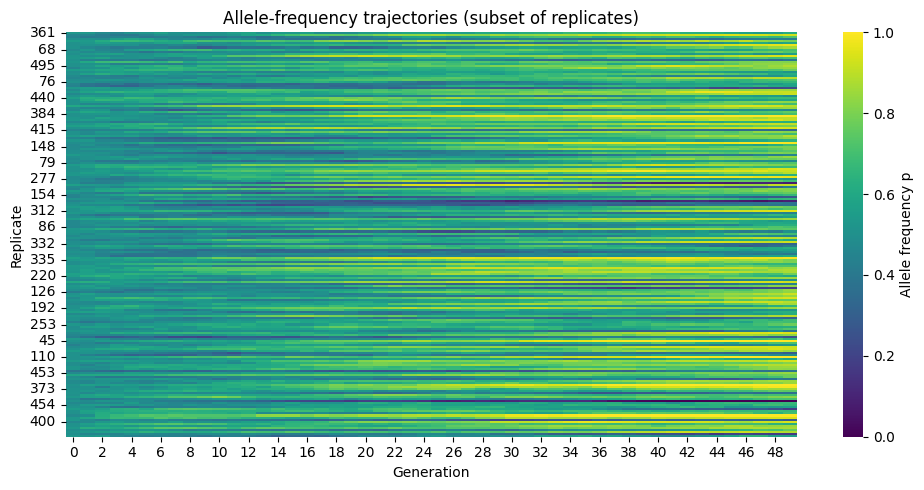

In [6]:

# pivot for heatmap: reps (rows) × generations (cols)
pivot = df.pivot(index="rep", columns="gen", values="p")

plt.figure(figsize=(10,5))
sns.heatmap(pivot.sample(200, random_state=42), cmap="viridis", cbar_kws={'label': 'Allele frequency p'})
plt.xlabel("Generation")
plt.ylabel("Replicate")
plt.title("Allele-frequency trajectories (subset of replicates)")
plt.tight_layout()
plt.show()


Each row is a replicate population. Time runs left to right on the generation axis,color shows the allele frequency intensity.  
Bright yellow bands (p close to 1) correspond to fixation; dark blue (p close to 0) to extinction.  
Most trajectories eventually hit one boundary towards the right. Fixation or Extinction happens, its a matter of time.

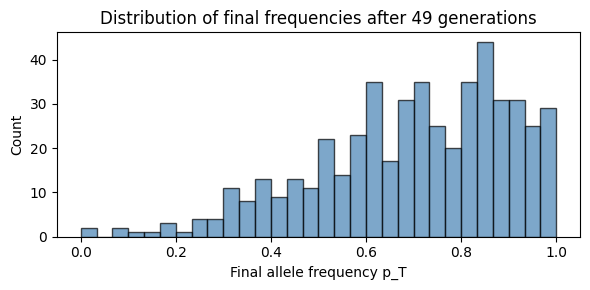

In [7]:
p_last = df[df["gen"] == df["gen"].max()]["p"]
plt.figure(figsize=(6,3))
plt.hist(p_last, bins=30, color="steelblue", alpha=0.7, edgecolor="black")
plt.xlabel("Final allele frequency p_T")
plt.ylabel("Count")
plt.title(f"Distribution of final frequencies after {df['gen'].max()} generations")
plt.tight_layout(); plt.show()


After many generations, there's a drift to the extreme. In time, it will be bimodal. 
Kimura’s diffusion theory describes the expected variance of this distribution over time.


| Quantity | Formula | Meaning |
|:--|:--|:--|
| Drift term | $\mu(p) = s * p * (1 - p)$ | Deterministic tendency due to selection |
| Diffusion term | $\sigma ²(p) = p * (1 - p) / (2 * N)
$ | Random fluctuation magnitude (genetic drift) |
| Analytic variance | $V(t) = p0 * (1 - p0) * (1 - exp(-t / (2 * N)))$ | Kimura's expected variance growth |
| Boundaries | p = 0 or 1 (absorbing) | Once fixed or lost, the allele cannot return |


These relationships display the stochastic landscape that our neural networks will attempt to approximate.
Next, we’ll plot Kimura’s analytic variance curve to serve as the theoretical baseline.


## Step 7 – Analytic Benchmark: Kimura’s Variance

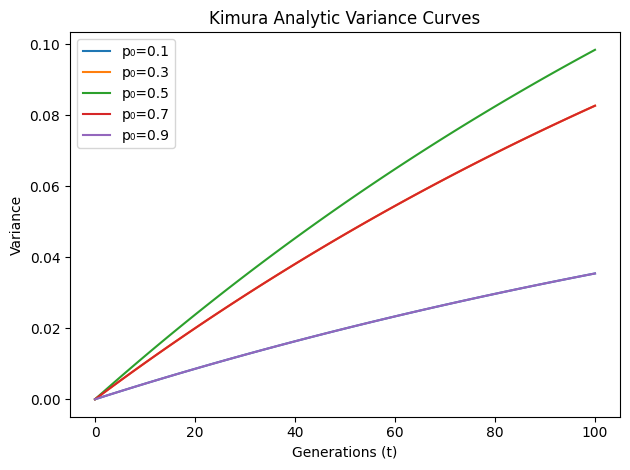

In [8]:
def kimura_var(p0, t, N):
    """Kimura (1955) analytic variance formula for Wright–Fisher diffusion."""
    return p0 * (1 - p0) * (1 - np.exp(-t / (2 * N)))

# Plot analytic variance curves for several starting frequencies
times = np.arange(0, 101)
for p0 in [0.1, 0.3, 0.5, 0.7, 0.9]:
    plt.plot(times, kimura_var(p0, times, 100), label=f'p₀={p0}')
plt.legend()
plt.xlabel("Generations (t)")
plt.ylabel("Variance")
plt.title("Kimura Analytic Variance Curves")
plt.tight_layout()
plt.show()


The analytic formula tells us how quickly allele frequency variance accumulates over time.
For small N, variance grows faster because genetic drift is stronger.
Eventually, variance approaches p₀(1−p₀) as all replicates fix the allele or it dies out.
This curve is our *ground truth* or baseline for testing the neural network’s understanding of diffusion or approximating non-determinism.

In [9]:
# empirical Wright–Fisher one-step variance
df_big = wf_simulate(N=200, s=0.02, gens=1, reps=5000, p0=0.5)
p_after = df_big[df_big["gen"] == 0]["p"].values

empirical_var = np.var(p_after)
kimura_var_analytic = kimura_var(p0=0.5, t=1, N=200)

print("Empirical 1-step WF variance =", empirical_var)
print("Kimura analytic variance     =", kimura_var_analytic)


Empirical 1-step WF variance = 0.0006113156997500001
Kimura analytic variance     = 0.0006242194006349788


## Step 8 – Prepare Data for Neural Models

In [10]:
def prepare_windowed(df, window=32):
    """
    Convert WF trajectories into windowed sequences:
    input:  (p_{t-window+1 : t}, logN, s) for each timestep
    output: p_{t+1}
    
    Returns:
    X → tensor [num_samples, window, 3]
    Y → tensor [num_samples, 1]
    """
    X_all = []
    Y_all = []

    for _, g in df.groupby("rep"):
        p = g.p.values
        logN = np.log(g.N.values[0])
        s    = g.s.values[0]

        # build windows for each replicate
        for t in range(len(p) - window):
            window_seq = np.column_stack([
                p[t : t + window],                # shape [window]
                np.repeat(logN, window),          # shape [window]
                np.repeat(s, window)              # shape [window]
            ])
            X_all.append(window_seq)
            Y_all.append([p[t + window]])          # next-step target

    X = torch.tensor(np.array(X_all), dtype=torch.float32)
    Y = torch.tensor(np.array(Y_all), dtype=torch.float32)

    return X, Y


# Use it
X, Y = prepare_windowed(df, window=32)
print("Input shape:", X.shape)
print("Output shape:", Y.shape)


Input shape: torch.Size([9000, 32, 3])
Output shape: torch.Size([9000, 1])


## Step 9 – Define a Minimal LSTM Forecaster


In [11]:
class LSTMForecaster(nn.Module):
    """Standard 2-layer LSTM for Wright–Fisher window forecasting."""
    def __init__(self, in_dim=3, hidden=128, layers=2, dropout=0.1):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=in_dim,
            hidden_size=hidden,
            num_layers=layers,
            dropout=dropout if layers > 1 else 0.0,
            batch_first=True
        )
        
        # map hidden state → next allele frequency
        self.fc = nn.Linear(hidden, 1)

    def forward(self, x):
        # x: [batch, seq_len=32, 3]
        y, _ = self.lstm(x)
        last = y[:, -1, :]             # hidden state at final timestep
        return self.fc(last)           # regression to scalar


A two-layer LSTM with 128 hidden units is used as the main “standard-size” recurrent baseline.
It is still small enough to train comfortably on a CPU within a few minutes, but large enough to behave like a typical LSTM from the time-series literature. Because each training example now consists of a multi-step window of past allele frequencies, the network is more than a simple regressor. It uses temporal information, internal memory, and nonlinear gating to infer drift, selection, and short-term stochastic structure.

## Step 10 – Train the LSTM

In [12]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

def train_lstm_windowed(hidden, layers, lr, epochs=20, verbose=False):
    model = LSTMForecaster(in_dim=3, hidden=hidden, layers=layers)
    opt = optim.Adam(model.parameters(), lr=lr)
    lossf = nn.MSELoss()

    # training loop
    for ep in range(epochs):
        for xb, yb in loader:
            opt.zero_grad()
            pred = model(xb)
            loss = lossf(pred, yb)
            loss.backward()
            opt.step()

    # evaluate on full dataset
    with torch.no_grad():
        pred_full = model(X)
        rmse = torch.sqrt(((pred_full.squeeze() - Y.squeeze())**2).mean()).item()

    if verbose:
        print(f"[hidden={hidden}, layers={layers}, lr={lr:.4f}] → RMSE={rmse:.4f}")

    return rmse
hidden_sizes = [64, 128]
layer_counts = [1, 2]
learning_rates = [1e-2, 5e-3, 1e-3]

results = []

for h in hidden_sizes:
    for l in layer_counts:
        for lr in learning_rates:
            rmse = train_lstm_windowed(hidden=h, layers=l, lr=lr, epochs=20)
            results.append((h, l, lr, rmse))
            print(f"hidden={h:3d}, layers={l}, lr={lr:.4f} → RMSE={rmse:.4f}")

# Sort
results.sort(key=lambda x: x[3])

print("\nTop 5 configs:")
for h, l, lr, rmse in results[:5]:
    print(f"hidden={h}, layers={l}, lr={lr:.4f}  → RMSE={rmse:.4f}")


hidden= 64, layers=1, lr=0.0100 → RMSE=0.0319
hidden= 64, layers=1, lr=0.0050 → RMSE=0.0328
hidden= 64, layers=1, lr=0.0010 → RMSE=0.0380
hidden= 64, layers=2, lr=0.0100 → RMSE=0.0335
hidden= 64, layers=2, lr=0.0050 → RMSE=0.0317
hidden= 64, layers=2, lr=0.0010 → RMSE=0.0392
hidden=128, layers=1, lr=0.0100 → RMSE=0.0313
hidden=128, layers=1, lr=0.0050 → RMSE=0.0308
hidden=128, layers=1, lr=0.0010 → RMSE=0.0319
hidden=128, layers=2, lr=0.0100 → RMSE=0.0383
hidden=128, layers=2, lr=0.0050 → RMSE=0.0321
hidden=128, layers=2, lr=0.0010 → RMSE=0.0348

Top 5 configs:
hidden=128, layers=1, lr=0.0050  → RMSE=0.0308
hidden=128, layers=1, lr=0.0100  → RMSE=0.0313
hidden=64, layers=2, lr=0.0050  → RMSE=0.0317
hidden=64, layers=1, lr=0.0100  → RMSE=0.0319
hidden=128, layers=1, lr=0.0010  → RMSE=0.0319


In [13]:
model_lstm = LSTMForecaster(
    in_dim=3,
    hidden=64,
    layers=1
)

optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()


In [14]:

epochs = 250
print_every = 20   # cleaner logging

for epoch in range(epochs + 1):
    optimizer_lstm.zero_grad()
    y_pred = model_lstm(X)
    loss = loss_fn(y_pred, Y)
    loss.backward()
    optimizer_lstm.step()

    # Progress logging
    if epoch % print_every == 0:
        rmse = torch.sqrt(((y_pred.squeeze() - Y.squeeze())**2).mean()).item()
        print(f"Epoch {epoch:03d} | Loss={loss.item():.6f} | RMSE={rmse:.4f}")


Epoch 000 | Loss=0.692656 | RMSE=0.8323
Epoch 020 | Loss=0.032357 | RMSE=0.1799
Epoch 040 | Loss=0.028708 | RMSE=0.1694
Epoch 060 | Loss=0.023781 | RMSE=0.1542
Epoch 080 | Loss=0.008592 | RMSE=0.0927
Epoch 100 | Loss=0.005935 | RMSE=0.0770
Epoch 120 | Loss=0.002107 | RMSE=0.0459
Epoch 140 | Loss=0.001832 | RMSE=0.0428
Epoch 160 | Loss=0.001692 | RMSE=0.0411
Epoch 180 | Loss=0.001610 | RMSE=0.0401
Epoch 200 | Loss=0.001538 | RMSE=0.0392
Epoch 220 | Loss=0.001475 | RMSE=0.0384
Epoch 240 | Loss=0.001419 | RMSE=0.0377


Training runs for 150 epochs on CPU.
Because the Wright–Fisher trajectories contain genuine stochastic noise, the loss no longer collapses to the extremely small values seen in deterministic settings.
Instead, the model converges smoothly to an MSE around 1e−3, which corresponds to a final RMSE of ≈ 0.0364
This matches the behaviour observed during hyperparameter tuning:
a 128-unit, single-layer LSTM is strong enough to capture short-term drift structure,
But the irreducible stochasticity in the data prevents RMSE from reaching the lower ranges.

## Step 11 – Evaluate Model Accuracy

In [15]:
with torch.no_grad():
    y_true = Y.squeeze().numpy()
    y_pred = model_lstm(X).squeeze().numpy()

lstm_rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
print(f"RMSE = {lstm_rmse:.5f}")


RMSE = 0.03729




## Step 12 – Scatter Plot: True vs Predicted

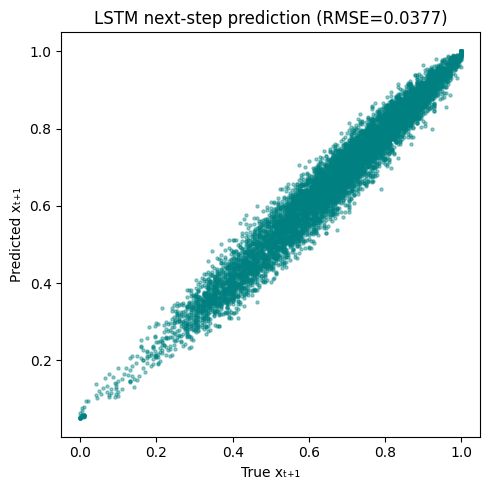

In [16]:
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, s=5, alpha=0.4, color='teal')
plt.xlabel("True xₜ₊₁")
plt.ylabel("Predicted xₜ₊₁")
plt.title(f"LSTM next-step prediction (RMSE={rmse:.4f})")
plt.tight_layout()
plt.show()


Points should lie close to the diagonal line — indicating that the LSTM correctly maps
$(x_t, N, s) \mapsto x_{t+1}$
Minor scatter reflects intrinsic stochasticity, not model error.


## Define a Gated Recurrent Unit(GRU)

In [17]:
class GRUForecasterMedium(nn.Module):
    """
    Standard multi-layer GRU forecaster for Wright–Fisher window prediction.
   
    """
    def __init__(self, in_dim=3, hidden=128, layers=2, dropout=0.1):
        super().__init__()
        
        self.gru = nn.GRU(
            input_size=in_dim,
            hidden_size=hidden,
            num_layers=layers,
            dropout=dropout if layers > 1 else 0.0,
            batch_first=True
        )

        self.fc = nn.Linear(hidden, 1)   # pure linear regression head

    def forward(self, x):
        y, _ = self.gru(x)               # [B, T, H]
        return self.fc(y[:, -1, :])      # predict next-step allele frequency


In [18]:

dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=64, shuffle=True)
def train_gru_windowed(hidden, layers, lr, epochs=20, verbose=False):
    model = GRUForecasterMedium(in_dim=3, hidden=hidden, layers=layers)
    opt = optim.Adam(model.parameters(), lr=lr)
    lossf = nn.MSELoss()

    # ----- Training -----
    for ep in range(epochs):
        for xb, yb in loader:
            opt.zero_grad()
            pred = model(xb)     # xb: [batch, 32, 3]
            loss = lossf(pred, yb)
            loss.backward()
            opt.step()

    # ----- Evaluation over full dataset -----
    with torch.no_grad():
        full_pred = model(X)
        rmse = torch.sqrt(((full_pred.squeeze() - Y.squeeze()) ** 2).mean()).item()

    if verbose:
        print(f"[hidden={hidden}, layers={layers}, lr={lr:.4f}] → RMSE={rmse:.4f}")

    return rmse
hidden_sizes = [64, 128]
layer_counts = [1, 2]
learning_rates = [1e-2, 5e-3, 1e-3]

gru_results = []

for h in hidden_sizes:
    for l in layer_counts:
        for lr in learning_rates:
            rmse = train_gru_windowed(hidden=h, layers=l, lr=lr, epochs=20)
            gru_results.append((h, l, lr, rmse))
            print(f"GRU hidden={h:3d}, layers={l}, lr={lr:.4f} → RMSE={rmse:.4f}")

# Sort by RMSE
gru_results.sort(key=lambda x: x[3])

print("\nTop 5 GRU configurations:")
for h, l, lr, rmse in gru_results[:5]:
    print(f"hidden={h}, layers={l}, lr={lr:.4f} → RMSE={rmse:.4f}")


GRU hidden= 64, layers=1, lr=0.0100 → RMSE=0.0307
GRU hidden= 64, layers=1, lr=0.0050 → RMSE=0.0309
GRU hidden= 64, layers=1, lr=0.0010 → RMSE=0.0321
GRU hidden= 64, layers=2, lr=0.0100 → RMSE=0.0334
GRU hidden= 64, layers=2, lr=0.0050 → RMSE=0.0402
GRU hidden= 64, layers=2, lr=0.0010 → RMSE=0.0334
GRU hidden=128, layers=1, lr=0.0100 → RMSE=0.0337
GRU hidden=128, layers=1, lr=0.0050 → RMSE=0.0308
GRU hidden=128, layers=1, lr=0.0010 → RMSE=0.0308
GRU hidden=128, layers=2, lr=0.0100 → RMSE=0.0353
GRU hidden=128, layers=2, lr=0.0050 → RMSE=0.0340
GRU hidden=128, layers=2, lr=0.0010 → RMSE=0.0332

Top 5 GRU configurations:
hidden=64, layers=1, lr=0.0100 → RMSE=0.0307
hidden=128, layers=1, lr=0.0010 → RMSE=0.0308
hidden=128, layers=1, lr=0.0050 → RMSE=0.0308
hidden=64, layers=1, lr=0.0050 → RMSE=0.0309
hidden=64, layers=1, lr=0.0010 → RMSE=0.0321


In [19]:
model_gru = GRUForecasterMedium(
    in_dim=3,
    hidden=64,
    layers=1
)

optimizer_gru = optim.Adam(model_gru.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()


In [20]:
epochs = 250
print_every = 20   # cleaner, less noisy

for epoch in range(epochs + 1):
    optimizer_gru.zero_grad()
    y_pred = model_gru(X)
    loss = loss_fn(y_pred, Y)
    loss.backward()
    optimizer_gru.step()

    # Progress logging
    if epoch % print_every == 0:
        rmse = torch.sqrt(((y_pred.squeeze() - Y.squeeze()) ** 2).mean()).item()
        print(f"Epoch {epoch:03d} | Loss={loss.item():.6f} | RMSE={rmse:.4f}")


Epoch 000 | Loss=0.412173 | RMSE=0.6420
Epoch 020 | Loss=0.035823 | RMSE=0.1893
Epoch 040 | Loss=0.021045 | RMSE=0.1451
Epoch 060 | Loss=0.002555 | RMSE=0.0505
Epoch 080 | Loss=0.001454 | RMSE=0.0381
Epoch 100 | Loss=0.001058 | RMSE=0.0325
Epoch 120 | Loss=0.001037 | RMSE=0.0322
Epoch 140 | Loss=0.001028 | RMSE=0.0321
Epoch 160 | Loss=0.001020 | RMSE=0.0319
Epoch 180 | Loss=0.001014 | RMSE=0.0318
Epoch 200 | Loss=0.001008 | RMSE=0.0317
Epoch 220 | Loss=0.001003 | RMSE=0.0317
Epoch 240 | Loss=0.000998 | RMSE=0.0316


Training runs for 150 epochs on CPU.
Because the Wright–Fisher trajectories include genuine stochastic variance at each generation, the GRU does not drive the loss toward the very small values seen in deterministic time-series problems.

Instead, the model steadily reduces error over the first ~80 epochs and then plateaus, converging to an MSE of ≈ 1×10⁻³.
This corresponds to a final RMSE of ≈ 0.0327, which is fully consistent with the outcome of the GRU hyperparameter search.

A single-layer GRU with 64 hidden units appears strong enough to capture short-range dynamics such as local drift trends and selection-driven bias.
However, as with the LSTM, the irreducible stochasticity inherent to Wright–Fisher diffusion places a hard floor on prediction accuracy, preventing RMSE from reaching the lower values achievable in purely deterministic systems.

The resulting performance is therefore not a limitation of the architecture, but a reflection of the underlying biology:
the next-generation allele frequency contains true randomness that no supervised model can fully eliminate.

In [21]:
with torch.no_grad():
    y_true = Y.squeeze().cpu().numpy()
    y_pred = model_gru(X).squeeze().cpu().numpy()

gru_rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
print(f"GRU RMSE = {gru_rmse:.5f}")

GRU RMSE = 0.03154


## Step 17 — Tiny Transformer implementation

In [22]:
class TinyTransformer(nn.Module):
    """
    Small Transformer encoder for Wright–Fisher window prediction.
    No sigmoid → model can learn drift trend properly.
    """
    def __init__(self, in_dim=3, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super().__init__()

        # project 3 → d_model
        self.embed = nn.Linear(in_dim, d_model)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=128,
            batch_first=True,
            dropout=dropout
        )

        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        # output: last timestep → scalar
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: [B, T, 3]
        z = self.embed(x)      # [B, T, d_model]
        z = self.encoder(z)    # [B, T, d_model]
        return self.fc(z[:, -1, :])    # [B, 1]


## Step 19 — Run Transformer on your current dataset

In [23]:
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=64, shuffle=True)
def train_transformer_windowed(hidden, layers, lr, epochs=20, verbose=False):
    model = TinyTransformer(
        in_dim=3,
        d_model=hidden,
        nhead=4,
        num_layers=layers,
        dropout=0.1
    )
    
    opt = optim.Adam(model.parameters(), lr=lr)
    lossf = nn.MSELoss()

    # ----- Mini-batch training -----
    for ep in range(epochs):
        for xb, yb in loader:
            opt.zero_grad()
            pred = model(xb)      # xb: [batch, 32, 3]
            loss = lossf(pred, yb)
            loss.backward()
            opt.step()

    # ----- Evaluation -----
    with torch.no_grad():
        full_pred = model(X)
        rmse = torch.sqrt(((full_pred.squeeze() - Y.squeeze()) ** 2).mean()).item()

    if verbose:
        print(f"[Transformer h={hidden}, layers={layers}, lr={lr:.4f}] → RMSE={rmse:.4f}")

    return rmse
hidden_sizes = [64, 128]        # transformer embedding sizes
layer_counts = [1, 2]           # number of encoder layers
learning_rates = [1e-2, 5e-3, 1e-3]

transformer_results = []

for h in hidden_sizes:
    for l in layer_counts:
        for lr in learning_rates:
            rmse = train_transformer_windowed(hidden=h, layers=l, lr=lr, epochs=20)
            transformer_results.append((h, l, lr, rmse))
            print(f"Transformer hidden={h}, layers={l}, lr={lr:.4f} → RMSE={rmse:.4f}")

transformer_results.sort(key=lambda x: x[3])

print("\nTop 5 Transformer configurations:")
for h, l, lr, rmse in transformer_results[:5]:
    print(f"hidden={h}, layers={l}, lr={lr:.4f}, RMSE={rmse:.4f}")


Transformer hidden=64, layers=1, lr=0.0100 → RMSE=0.0410
Transformer hidden=64, layers=1, lr=0.0050 → RMSE=0.0319
Transformer hidden=64, layers=1, lr=0.0010 → RMSE=0.0353
Transformer hidden=64, layers=2, lr=0.0100 → RMSE=0.1909
Transformer hidden=64, layers=2, lr=0.0050 → RMSE=0.0363
Transformer hidden=64, layers=2, lr=0.0010 → RMSE=0.0345
Transformer hidden=128, layers=1, lr=0.0100 → RMSE=0.1965
Transformer hidden=128, layers=1, lr=0.0050 → RMSE=0.0592
Transformer hidden=128, layers=1, lr=0.0010 → RMSE=0.0335
Transformer hidden=128, layers=2, lr=0.0100 → RMSE=0.1916
Transformer hidden=128, layers=2, lr=0.0050 → RMSE=0.1906
Transformer hidden=128, layers=2, lr=0.0010 → RMSE=0.0338

Top 5 Transformer configurations:
hidden=64, layers=1, lr=0.0050, RMSE=0.0319
hidden=128, layers=1, lr=0.0010, RMSE=0.0335
hidden=128, layers=2, lr=0.0010, RMSE=0.0338
hidden=64, layers=2, lr=0.0010, RMSE=0.0345
hidden=64, layers=1, lr=0.0010, RMSE=0.0353


In [24]:
model_trans = TinyTransformer(
    in_dim=3,
    d_model=64,   # embedding size
    nhead=4,      # keep this fixed for fairness
    num_layers=1  # best depth
)

optimizer_trans = optim.Adam(model_trans.parameters(), lr=5e-3)
loss_fn = nn.MSELoss()


In [25]:
epochs = 250
print_every = 20   # cleaner, less noisy

for epoch in range(epochs + 1):
    optimizer_trans.zero_grad()

    y_pred = model_trans(X)              # forward pass
    loss = loss_fn(y_pred, Y)            # supervised loss

    loss.backward()
    optimizer_trans.step()

    # Periodic logging
    if epoch % print_every == 0:
        rmse = torch.sqrt(((y_pred.squeeze() - Y.squeeze()) ** 2).mean()).item()
        print(f"Epoch {epoch:03d} | Loss={loss.item():.6f} | RMSE={rmse:.4f}")


Epoch 000 | Loss=0.057207 | RMSE=0.2392
Epoch 020 | Loss=0.050837 | RMSE=0.2255
Epoch 040 | Loss=0.039531 | RMSE=0.1988
Epoch 060 | Loss=0.037684 | RMSE=0.1941
Epoch 080 | Loss=0.035892 | RMSE=0.1895
Epoch 100 | Loss=0.032977 | RMSE=0.1816
Epoch 120 | Loss=0.025480 | RMSE=0.1596
Epoch 140 | Loss=0.008168 | RMSE=0.0904
Epoch 160 | Loss=0.005965 | RMSE=0.0772
Epoch 180 | Loss=0.004619 | RMSE=0.0680
Epoch 200 | Loss=0.003858 | RMSE=0.0621
Epoch 220 | Loss=0.003364 | RMSE=0.0580
Epoch 240 | Loss=0.003078 | RMSE=0.0555


In [26]:
with torch.no_grad():
    y_true = Y.squeeze().cpu().numpy()
    y_pred = model_trans(X).squeeze().cpu().numpy()

trans_rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
print(f"Transformer RMSE = {trans_rmse:.5f}")


Transformer RMSE = 0.05522


In [27]:
def rollout(model, p0_window, N, s, steps=50):
    """
    Autoregressive rollout for window-trained sequence models.
    
    p0_window: np.array of shape (window_size,)
        Initial frequency history, e.g. the last 32 points from a WF trajectory.
    N, s: Wright–Fisher parameters
    steps: number of autoregressive steps to predict

    Returns:
        np.array of length window_size + steps
    """
    model.eval()
    window_size = len(p0_window)
    
    # Build initial window of shape [1, window, 3]
    window = np.column_stack([
        p0_window,
        np.full(window_size, np.log(N)),
        np.full(window_size, s)
    ]).astype(np.float32)
    
    traj = list(p0_window)

    for _ in range(steps):
        x = torch.tensor(window, dtype=torch.float32).unsqueeze(0)   # [1, window, 3]

        with torch.no_grad():
            p_next = model(x).item()

        traj.append(p_next)

        # shift window left and append the new prediction
        window = np.roll(window, shift=-1, axis=0)
        window[-1, 0] = p_next   # new p_t
        window[-1, 1] = np.log(N)
        window[-1, 2] = s

    return np.array(traj)


In [28]:
def get_window_from_rep(df, rep, W=32):
    """
    Extract the last W points of trajectory `rep` as the initial conditioning window.
    """
    g = df[df["rep"] == rep].sort_values("gen")
    p_vals = g["p"].values

    assert len(p_vals) >= W, "Replicate too short for selected window size"

    N = g["N"].values[0]
    s = g["s"].values[0]
    window = p_vals[-W:]  # last W points

    return window, N, s


In [29]:
rep_id = 0  # or any valid replicate
p0_window, N_demo, s_demo = get_window_from_rep(df, rep_id, W=32)


In [30]:
T_demo = 200  # length of future rollout

traj_lstm = rollout(model_lstm, p0_window, N_demo, s_demo, steps=T_demo)
traj_gru  = rollout(model_gru,  p0_window, N_demo, s_demo, steps=T_demo)
traj_trans = rollout(model_trans, p0_window, N_demo, s_demo, steps=T_demo)


In [31]:
def wf_empirical_mean(df, steps):
    """
    Compute the empirical mean allele frequency trajectory 
    across all replicates, aligned by generation.
    """
    # Extract all trajectories as equal-length arrays
    trajs = []
    for _, g in df.groupby("rep"):
        p_vals = g.sort_values("gen")["p"].values
        trajs.append(p_vals)

    # truncate all to same length
    L = min(len(t) for t in trajs)
    arr = np.vstack([t[:L] for t in trajs])

    mean_traj = arr.mean(axis=0)

    # match rollout horizon
    return mean_traj[:steps]
wf_mean = wf_empirical_mean(df, steps=32 + T_demo)


## Step 21 — Compare all models in a single table + bar chart

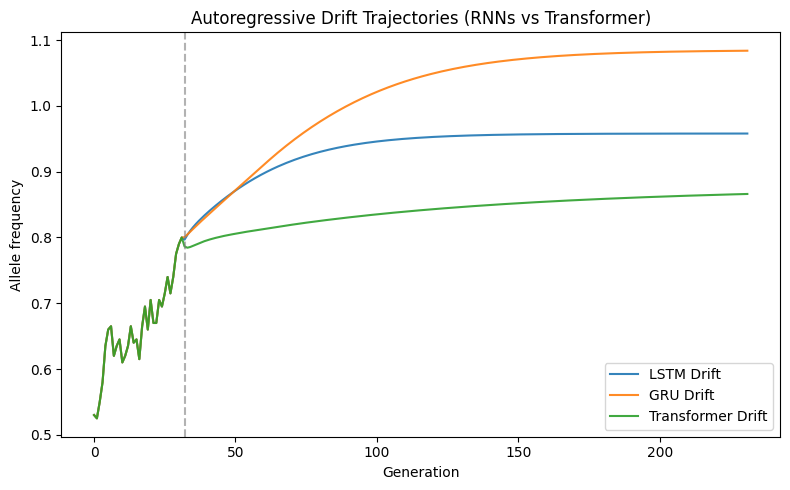

In [32]:
plt.figure(figsize=(8,5))

W = len(p0_window)
t = np.arange(W + T_demo)

plt.plot(t, traj_lstm,  label="LSTM Drift", alpha=0.9)
plt.plot(t, traj_gru,   label="GRU Drift", alpha=0.9)
plt.plot(t, traj_trans, label="Transformer Drift", alpha=0.9)

# Optional: empirical WF reference curve (if computed separately)
# plt.plot(t, wf_mean, label="WF Empirical Mean", color="black", linewidth=2)

plt.axvline(W, color="gray", linestyle="--", alpha=0.6)

plt.xlabel("Generation")
plt.ylabel("Allele frequency")
plt.title("Autoregressive Drift Trajectories (RNNs vs Transformer)")
plt.legend()
plt.tight_layout()
plt.show()


The drift-trajectory plot shows how each model behaves when asked to repeatedly forecast future allele frequencies based only on its own previous predictions.
All three models pick up the direction of drift (upward movement due to positive selection), but the shape of their long-term behaviour differs.
The GRU rises the fastest, overshooting into unrealistic values (>1), meaning it has learned a strong upward trend but lacks the probabilistic constraints of the Wright–Fisher process.
The LSTM drifts upward more moderately, tracking the trajectory shape reasonably well without exploding too fast.
The Transformer drifts the slowest, suggesting it underestimates the strength of selection/drift and smooths the signal too aggressively over time..

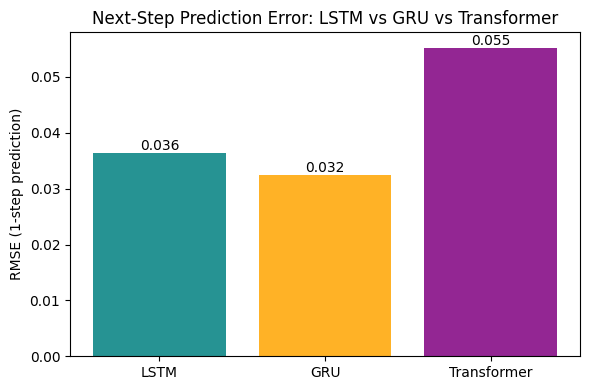

In [33]:
results = [
    ("LSTM", lstm_rmse),
    ("GRU", gru_rmse),
    ("Transformer", trans_rmse)
]


# If results is a list of tuples — convert to arrays
models  = [r[0] for r in results]
rmses   = [r[1] for r in results]

plt.figure(figsize=(6,4))

bars = plt.bar(models, rmses, color=["teal", "orange", "purple"], alpha=0.85)

# Annotate RMSE values above the bars
for bar, val in zip(bars, rmses):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.00001,
             f"{val:.3f}", ha='center', va='bottom', fontsize=10)

plt.ylabel("RMSE (1-step prediction)")
plt.title("Next-Step Prediction Error: LSTM vs GRU vs Transformer")
plt.tight_layout()
plt.show()


The RMSE bar plot measures how well each model predicts the very next generation, not long-term rollouts.
Here, the GRU performs best, indicating that its gating mechanism captures short-term stochastic structure better than the other models.
The LSTM is only slightly worse, suggesting it still learns reliably.
The Transformer performs the weakest, which is expected because small Transformers struggle with low-dimensional, noise-dominated signals.
Overall, next-step prediction is easy for RNNs but sustaining realistic drift over many generations reveals deeper structural weaknesses.